In [1]:
import os
import numpy as np

from cv2 import imread
import cv2 as cv
import zipfile
import math

import imgaug as ia
from imgaug import augmenters 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import layers,Input,Model,callbacks
import keras_tuner as kt

from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras import activations,Sequential

import pandas as pd

In [2]:
zipped_path = './Data/zipped/'
path = './Data/unzipped/'


augmented_train_x_path='./Data/aug x'
os.mkdir(augmented_train_x_path)
augmented_train_x_path2='./Data/aug x/img'

augmented_train_y_path='./Data/aug y'
os.mkdir(augmented_train_y_path)
augmented_train_y_path2='./Data/aug y/img'

In [3]:
with zipfile.ZipFile(zipped_path + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(zipped_path + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(zipped_path + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
with zipfile.ZipFile(zipped_path + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [4]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [5]:
def process_image(path):
    img = np.asarray(cv.imread(path), dtype="float32")
    img = cv.resize(img, (540, 420))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = img/255.0    
    return img

In [6]:
train_x = []
train_y= []
test_x = []

for f in sorted(os.listdir(path + 'train/')):
    train_x.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_y.append(process_image(path + 'train_cleaned/' + f))
    
for f in sorted(os.listdir(path + 'test/')):
    test_x.append(process_image(path + 'test/' + f))

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x)

# <center> `Data Augmentaion Pipeline`  </center>

In [7]:
def image_augmentaion(pipeline, images):
    ia.seed(1)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [8]:
rot_90 = augmenters.Rot90(1) #rot_90 = augmenters.Rot90(times) #time=1 =>90deg, time=2 =>180deg, time=3 =>270deg
rot_180 = augmenters.Rot90(2) 
rot_270 = augmenters.Rot90(3)
flip_hor = augmenters.Fliplr(1) 
fli_vert = augmenters.Flipud(1)
perspective_transform = augmenters.PerspectiveTransform(scale=(0.01, 0.15))

pipeline = [rot_90, rot_180, rot_270, flip_hor, fli_vert,perspective_transform]


In [9]:
train_x_aug = image_augmentaion(pipeline, train_x)
train_y_aug = image_augmentaion(pipeline, train_y)

In [10]:
for i in range(train_x_aug.shape[0]):
    x_path=os.path.join(augmented_train_x_path, str(i)+'.jpg')
    y_path=os.path.join(augmented_train_y_path, str(i)+'.jpg')
    cv.imwrite(x_path, train_x_aug[i]*255)
    cv.imwrite(y_path, train_y_aug[i]*255)

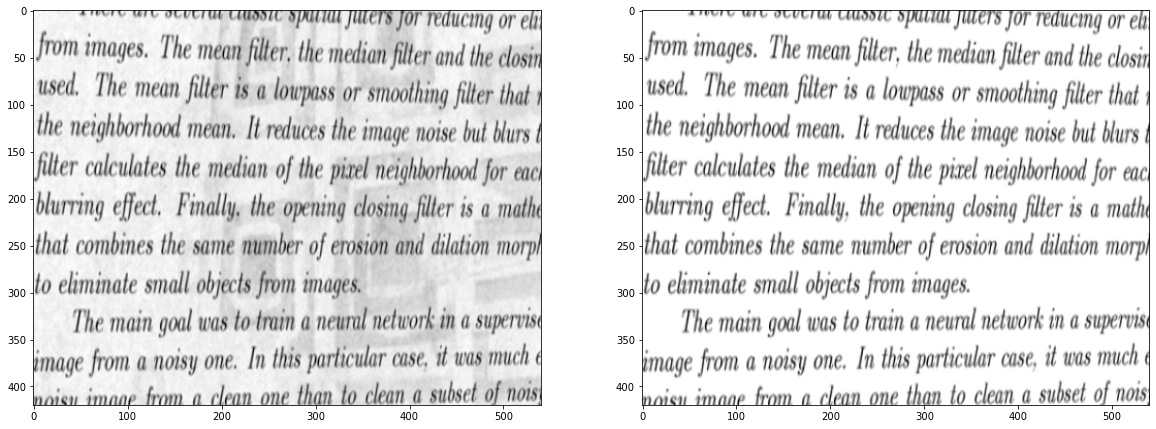

In [11]:

f, axarr = plt.subplots(1,2) 
plt.gcf().set_size_inches(20, 10)

axarr[0].imshow(train_x_aug[1000], cmap='gray')
axarr[1].imshow(train_y_aug[1000], cmap='gray')


In [12]:
for i in range(train_x_aug.shape[0]):
    x_path=os.path.join(augmented_train_x_path, str(i)+'.jpg')
    y_path=os.path.join(augmented_train_y_path, str(i)+'.jpg')
    cv.imwrite(x_path, train_x_aug[i]*255)
    cv.imwrite(y_path, train_y_aug[i]*255)

In [13]:
def load_and_split_data(augmented_train_x_path,augmented_train_y_path):


    arr = os.listdir(augmented_train_x_path)
    arr.sort()
    arr=arr[1:]

    x_set = [os.path.join(augmented_train_x_path, dir) for dir in arr]
    y_set = [os.path.join(augmented_train_y_path, dir) for dir in arr]

    x_train, x_valid, y_train, y_valid = train_test_split(x_set, y_set, test_size=0.15, random_state=42)
    
    return x_train, x_valid, y_train, y_valid 

    
def custom_generator(x_set,y_set,batch_size=4):

    class Custom_Sequence(Sequence):

        def __init__(self, x_set, y_set, batch_size):
            self.x, self.y = x_set, y_set
            self.batch_size = batch_size

        def __len__(self):
            return math.ceil(len(self.x) / self.batch_size)

        def __getitem__(self, idx):
            batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

            return np.array([(imread(file_name, 0)/255.) for file_name in batch_x]), np.array([(imread(file_name, 0)/255.) for file_name in batch_y])

    generator = Custom_Sequence(x_set, y_set, batch_size)
    
    return generator

In [14]:
x_train, x_valid, y_train, y_valid = load_and_split_data(augmented_train_x_path,augmented_train_y_path)

In [15]:
train_generator = custom_generator(x_train,y_train,16)
valid_generator = custom_generator(x_valid,y_valid,16)

In [16]:

def auto_encoder():
    input_shape=(420, 540,1)
    
    input_img = Input(shape=input_shape)
    
    x      = layers.Conv2D(filters=32,kernel_size=3, padding='same',activation='relu')(input_img)
    x      = layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(x)
    x      = layers.Dropout(rate=0.33)(x)

    x      = layers.Conv2D(filters=92,kernel_size=3, padding='same')(x)
    x      = layers.BatchNormalization()(x) 
    x      = layers.Activation(activations.relu)(x)
    x      = layers.MaxPooling2D(2)(x)
    En_out = layers.Dropout(rate=0.33)(x)

    
        
    De_in  = layers.UpSampling2D(2)(En_out)
    x      = layers.Conv2DTranspose(filters=92,kernel_size=3,padding='same')(De_in)
    x      = layers.BatchNormalization()(x) 
    x      = layers.Activation(activations.relu)(x)
    
    x      = layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x      = layers.Conv2DTranspose(filters=32,kernel_size=3,padding='same',activation='relu')(x)
    x      = layers.Dropout(rate=0.33)(x)
    
    out_img= layers.Conv2DTranspose(filters=1,kernel_size=3,padding='same',activation='sigmoid')(x)
        

    model=Model(input_img, out_img)

    

    learning_rate=1e-4
    decay_rate = learning_rate / 10
    optimizer   = keras.optimizers.Adam(learning_rate=learning_rate,decay=decay_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

              

In [17]:
autoencoder=auto_encoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 420, 540, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 92)      53084     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 92)     368       
 ormalization)                                                   
                                                             

2022-03-24 21:37:20.430811: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 21:37:20.430861: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UB): /proc/driver/nvidia/version does not exist
2022-03-24 21:37:20.431575: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=25, verbose=1, restore_best_weights=True)
tensor_board   = callbacks.TensorBoard("/tmp/tb_logs")

In [19]:
weights_file = 'autoencoder_denoising.h5'

if os.path.exists(weights_file):
    autoencoder.load_weights(weights_file)
    my_history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print('Loaded weights!')
else:
    history_keras =  autoencoder.fit(train_generator, epochs=300, validation_data=valid_generator, callbacks=[early_stopping])
    autoencoder.save_weights('autoencoder_denoising.h5')
    np.save('my_history.npy',history_keras.history)
    my_history=history_keras.history

Loaded weights!


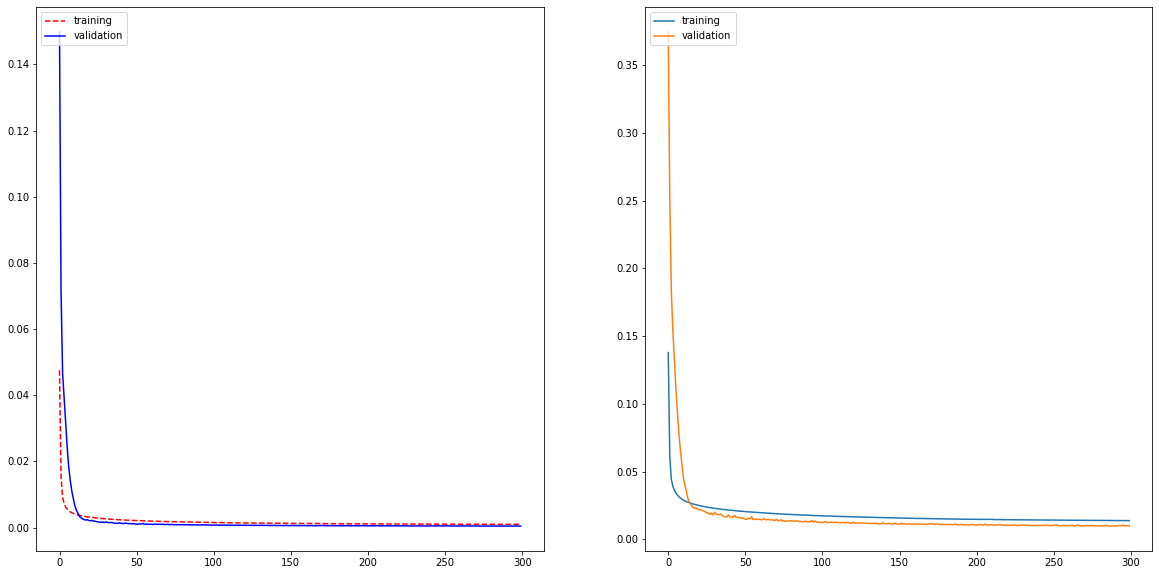

In [20]:

f, axarr = plt.subplots(1,2) 
plt.gcf().set_size_inches(20, 10)

axarr[0].plot(my_history['loss'], 'r--')
axarr[0].plot(my_history['val_loss'], 'b-')
axarr[0].legend(['training', 'validation'], loc = 'upper left')

axarr[1].plot(my_history['mean_absolute_error'])
axarr[1].plot(my_history['val_mean_absolute_error'])
axarr[1].legend(['training', 'validation'], loc = 'upper left')


plt.show()

In [21]:
y_pred = autoencoder.predict(test_x, batch_size=1)

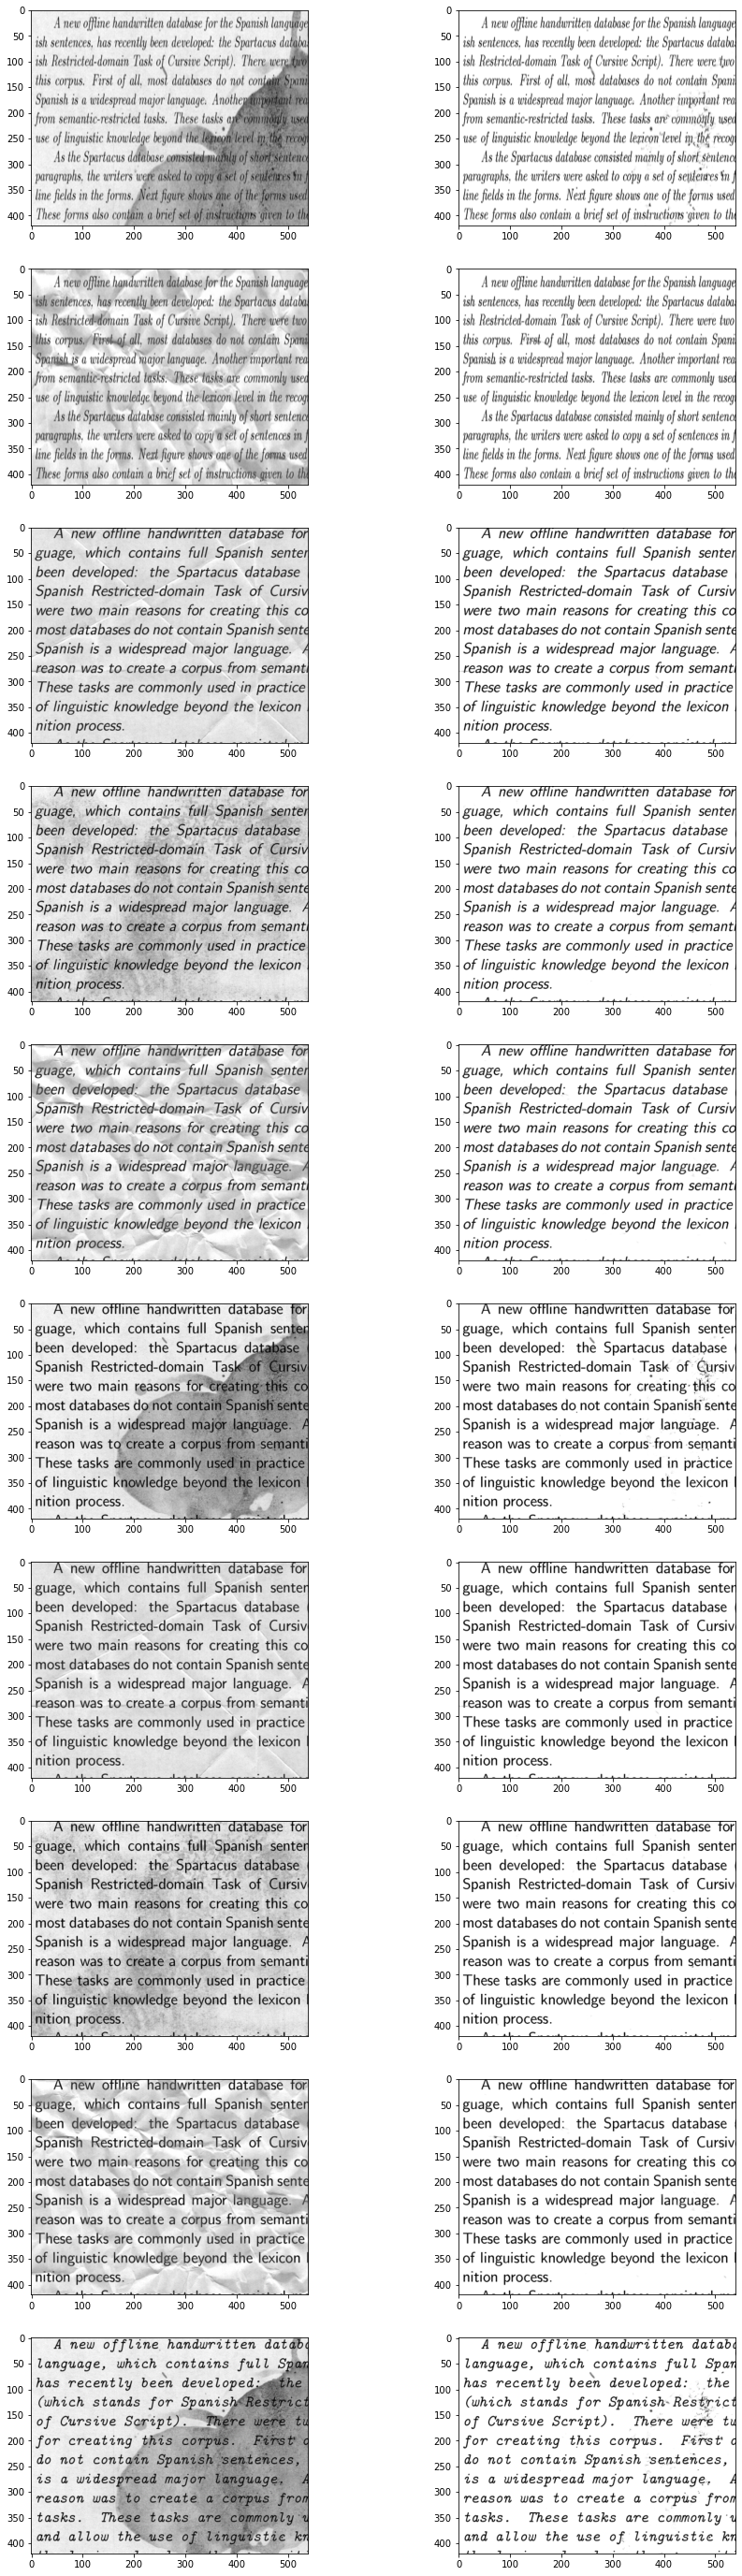

In [35]:
f, axarr = plt.subplots(10,2) 
plt.gcf().set_size_inches(15, 50)
for i in range(0,10):
    axarr[i][0].imshow(test_x[i], cmap='gray')
    axarr[i][1].imshow(y_pred[i][...,0], cmap='gray')
